In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from utils import init_random_seed, tokenize_text_simple_regex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
SEED = 1
TRAIN_MODEL = False # if True, then train model and save it. if False, just load it
PATH_MODEL = "./Pre-trained Models/tfidf_xgb_request_category.pkl"
PATH_DATASET = './Data/Dataset_cleaned.csv'

In [ ]:
init_random_seed(SEED)

In [12]:
dataset = pd.read_csv(PATH_DATASET).iloc[:, :2]
dataset.head()

,Request category,Application description
0,Благоустройство территории,На трассе Нижнекамск-Чистополь в лесополосе у ...
1,Благоустройство территории,Во дворе дома Ленинградская 29 отсутствуют пар...
2,Содержание и ремонт муниципальных дорог,Добрый день! Не осуществляется уборка снега в ...
3,Благоустройство территории,Добрый день! Не осуществляется вывоз мусора с ...
4,Содержание и ремонт муниципальных дорог,на данном участке проезжей части от ул.Халитов...


In [13]:
request_category_int = LabelEncoder().fit_transform(dataset['Request category'])
print(f"Unique classes of the variable Request category: {len(dataset['Request category'].unique())}")

Unique classes of the variable Request category: 26


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset['Application description'],
    request_category_int,
    test_size=0.3,
    shuffle=True,
    stratify=request_category_int,
    random_state=SEED
)

In [15]:
MAX_DF = 0.8
MIN_COUNT = 5
MIN_TOKEN_SIZE = 4

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda text: tokenize_text_simple_regex(text, min_token_size=MIN_TOKEN_SIZE),
    max_df=MAX_DF,
    min_df=MIN_COUNT,
    token_pattern=None,
    lowercase=False
)

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)
X_train.shape, X_test.shape

((17380, 6251), (7449, 6251))

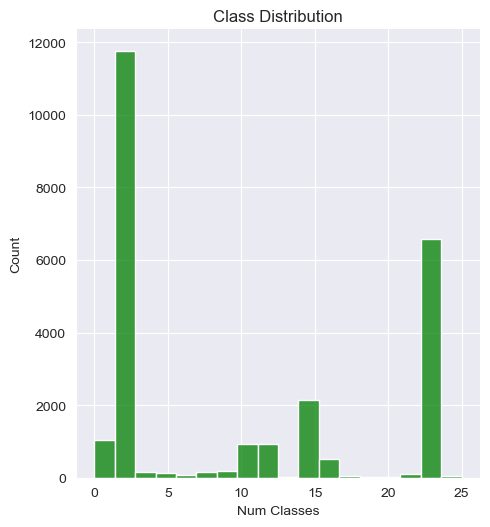

In [16]:
sns.displot(request_category_int, color='green')
plt.xlabel('Num Classes')
plt.title('Class Distribution');

In [17]:
parameters = {
    'objective': 'multi:softprob',
    'learning_rate': 1.0e-1,
    'n_estimators': 1000,
    'early_stopping_rounds': 15,
    'max_depth': 3,
    'subsample': 0.5,
    'eval_metric': ['merror', 'auc'],
    'verbosity': 1,
    'seed': SEED
}

if TRAIN_MODEL:
    xgb_clf = XGBClassifier(**parameters)
    
    xgb_clf.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )

    pickle.dump(xgb_clf, open(PATH_MODEL, "wb"))
else:
    xgb_clf = pickle.load(open(PATH_MODEL, 'rb'))

In [18]:
train_pred_proba = xgb_clf.predict_proba(X_train)
test_pred_proba = xgb_clf.predict_proba(X_test)
test_pred = xgb_clf.predict(X_test)

print(f"AUC Train: {roc_auc_score(y_train, train_pred_proba, multi_class='ovr'):.4f}\n"
      f"AUC Test: {roc_auc_score(y_test, test_pred_proba, multi_class='ovr'):.4f}\n"
      f"Accuracy score on Test: {accuracy_score(y_test, test_pred):.4f}")

AUC Train: 0.9876
AUC Test: 0.8943
Accuracy score on Test: 0.7730
